In [26]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn import metrics
from struct import unpack
import matplotlib.pyplot as plt

In [7]:
def load_mnist(image_file_name, label_file_name):
    images = open(image_file_name, 'rb')
    labels = open(label_file_name, 'rb')
    
    images.read(4) # I guess this is to dump some format specific non-data
    number_of_images = images.read(4) # I guess these bits actually have described how many images there are?
    number_of_images = unpack('>I', number_of_images)[0] # Okay this might be the decoding part.
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]
    labels.read(4) # this is once again just dumping 4 bytes for some reason
    N = labels.read(4)
    N = unpack('>I', N)[0] # Based on above, assuming this is the number of labels?
    
    total_number_pixels = rows * cols
    x = np.zeros((N, total_number_pixels), dtype=np.uint8) # N should be the same as number_of_images right?
    y = np.zeros(N, dtype=np.uint8) # Same, initialize with 0s
    for i in range(N):
        for j in range(total_number_pixels):
            tmp_pixel = images.read(1) # Read a pixel
            tmp_pixel = unpack('>B', tmp_pixel)[0] # Unpack with some other decoder?
            x[i][j] = tmp_pixel # Put pixel value into bitmap (flated into 1D per image)
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0] # Why are we using this decoder instead of >I again?
        
    images.close()
    labels.close()
    return (x,y)

In [39]:
train_img, train_lbl = load_mnist('../MNIST_dataset/train-images.idx3-ubyte', '../MNIST_dataset/train-labels.idx1-ubyte')
test_img, test_lbl = load_mnist('../MNIST_dataset/t10k-images.idx3-ubyte', '../MNIST_dataset/t10k-labels.idx1-ubyte')

In [40]:
num_train_img = train_img.shape[0]
train_img, validate_img = train_img[:int(0.8*num_train_img)], train_img[int(0.8*num_train_img):]
train_lbl, validate_lbl = train_lbl[:int(0.8*num_train_img)], train_lbl[int(0.8*num_train_img):]

In [9]:
train_img.shape

(60000, 784)

In [11]:
train_lbl.shape

(60000,)

In [12]:
test_img.shape

(10000, 784)

In [13]:
test_lbl.shape

(10000,)

In [16]:
lr_model = LogisticRegression(solver='lbfgs', n_jobs=-1, verbose=1) # I'd actually like to see what's printed

In [15]:
lr_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
lr_model.fit(train_img,train_lbl)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
lr_model.score(validate_img, validate_lbl)

0.91825

In [22]:
# So in the document it says "Inverse of regularization strength; must be a positive float. 
# Like in support vector machines, smaller values specify stronger regularization."
# What does this mean? Could larger C mean it's going to over fit?
C_param_range = [0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
train_accuracy = []
validate_accuracy = []

In [23]:
for c in C_param_range:
    lr_model = LogisticRegression(solver='lbfgs', n_jobs=-1, C=c)
    lr_model.fit(train_img,train_lbl)
    train_accuracy.append(lr_model.score(train_img,train_lbl))
    validate_accuracy.append(lr_model.score(validate_img, validate_lbl))

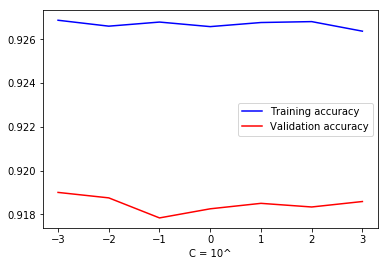

In [28]:
plt.plot(range(-3,4), train_accuracy, 'b-', range(-3,4), validate_accuracy, 'r-')
plt.legend(('Training accuracy', 'Validation accuracy'))
plt.xlabel('C = 10^')
plt.show()

In [41]:
# There's really no significant differnences, we'll stick with 10^-3 then, 
# since it has the highest accuracy and smaller C suppose to mean more general
train_img, train_lbl = np.concatenate((train_img, validate_img)), np.concatenate((train_lbl, validate_lbl))
lr_model = LogisticRegression(solver='lbfgs', n_jobs=-1, C=0.001)
lr_model.fit(train_img,train_lbl)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [49]:
result = lr_model.predict(test_img)
# Creat onehot encoding
onehot = np.zeros((result.size, 10))
onehot[np.arange(result.size), result] = 1
np.savetxt('lr.csv', onehot, delimiter=',',fmt='%i')

In [43]:
# I want to see how well it did
print(lr_model.score(test_img, test_lbl))

0.9175
